In [309]:
from markethistory import MarketHistory
from constants import * 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from supervised import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Example

In [3]:
start = "2017/07/27"
end = "2018/04/20"
data = MarketHistory(start,end)

In [4]:
data_ = data.data

In [5]:
data_.shape

(3, 11, 12817)

### Classification

In [157]:
len_window = 3000
prices_trading = data_[0,:,T-len_window:]
returns = np.diff(prices_trading,axis=1)
ret = (returns / prices_trading[:,:-1]).T

In [249]:
ret.shape

(9999, 11)

train error
[0]	eval-error:0.268846
test error
[0]	eval-error:0.450455


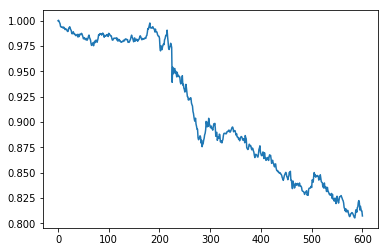

In [158]:
lookback = 10
n = len_window - 1
split_index = int(.8*n)
x_train = []
y_train = []
regression = False
use_prices = False
for i in range(lookback,split_index):
    for coin in range(11):
        if use_prices is True:
            x = np.append(data_[0,coin,i-lookback:i].reshape(-1,),i)
        else:
            x = np.append(ret[i-lookback:i,coin].reshape(-1,),i)
        x_train.append(x)
        y = ret[i,coin]
        if regression is False:
            if y > 0:
                y = 1
            else:
                y = 0
        y_train.append(y)
x_test = []
y_test = []
for i in range(split_index,n):
    for coin in range(11):
        if use_prices is True:
            x = np.append(data_[0,coin,i-lookback:i].reshape(-1,),i)
        else:
            x = np.append(ret[i-lookback:i,coin].reshape(-1,),i)
        x_test.append(x)
        y = ret[i,coin]
        if regression is False:
            if y > 0:
                y = 1
            else:
                y = 0
        y_test.append(y)
dtrain = xgb.DMatrix(np.array(x_train),label=np.array(y_train))
if regression is True:
    obj = "reg:linear"
else:
    obj = "binary:logistic"
param = {'max_depth':10, 'eta':.25, 'silent':0,'alpha':1,'min_child_weight':5, 'objective':obj }
num_round = 14
bst = xgb.train(param, dtrain, num_round)
print("train error")
print(bst.eval(dtrain))
print("test error")
dtest = xgb.DMatrix(np.array(x_test),label=np.array(y_test))
print(bst.eval(dtest))
preds = bst.predict(xgb.DMatrix(np.array(x_test)))
port = [1]
cutoff = 0.5
rs = []
for i in range(int(len(preds)/11)):
    r = 0
    for coin in range(11):
        if preds[i] > 0.5:
            r += ret[split_index+i,coin] / 11
        elif preds[i] <  0.5:
            r += -ret[split_index+i,coin] / 11
    val = port[-1] * (1+r)
    rs.append(r)
    port.append(val)
plt.plot(port)

In [329]:
float(bst.eval(dtrain)[15:20])

0.325

#### One model for each coin

In [160]:
len_window = 10000
prices_trading = data_[0,:,T-len_window:T]
returns = np.diff(prices_trading,axis=1)
ret = (returns / prices_trading[:,:-1]).T
lookback = 20
n = len_window - 1
split_index = int(.8*n)
regression = False
use_prices = False
X_train = {}
Y_train = {}
for coin in range(11):
    x_train = []
    y_train = []
    for i in range(lookback,split_index):
        if use_prices is True:
            x = np.append(data_[0,coin,i-lookback:i].reshape(-1,),i)
        else:
            x = np.append(ret[i-lookback:i,coin].reshape(-1,),i)
        x_train.append(x)
        y = ret[i,coin]
        if regression is False:
            if y > 0:
                y = 1
            else:
                y = 0
        y_train.append(y)
    X_train[coin] = x_train
    Y_train[coin] = y_train

X_test = {}
Y_test = {}
for coin in range(11):
    x_test = []
    y_test = []
    for i in range(split_index,n):
        if use_prices is True:
            x = np.append(data_[0,coin,i-lookback:i].reshape(-1,),i)
        else:
            x = np.append(ret[i-lookback:i,coin].reshape(-1,),i)
        x_test.append(x)
        y = ret[i,coin]
        if regression is False:
            if y > 0:
                y = 1
            else:
                y = 0
        y_test.append(y)
    X_test[coin] = x_test
    Y_test[coin] = y_test

In [203]:
preds = {}
for i in range(11):
    x_train = X_train[i]
    y_train = Y_train[i]
    x_test = X_test[i]
    y_test = Y_test[i]
    dtrain = xgb.DMatrix(np.array(x_train),label=np.array(y_train))
    if regression is True:
        obj = "reg:linear"
    else:
        obj = "binary:logistic"
    param = {'max_depth':5, 'eta':.5, 'silent':0,'alpha':1,'min_child_weight':5, 'objective':obj }
    num_round = 10
    bst = xgb.train(param, dtrain, num_round)
    print(i)
    print("train error")
    print(bst.eval(dtrain))
    print("test error")
    dtest = xgb.DMatrix(np.array(x_test),label=np.array(y_test))
    print(bst.eval(dtest))
    preds[i] = bst.predict(xgb.DMatrix(np.array(x_test)))

0
train error
[0]	eval-error:0.330994
test error
[0]	eval-error:0.493500
1
train error
[0]	eval-error:0.302294
test error
[0]	eval-error:0.401500
2
train error
[0]	eval-error:0.333751
test error
[0]	eval-error:0.488500
3
train error
[0]	eval-error:0.325605
test error
[0]	eval-error:0.491500
4
train error
[0]	eval-error:0.319213
test error
[0]	eval-error:0.489500
5
train error
[0]	eval-error:0.279484
test error
[0]	eval-error:0.337500
6
train error
[0]	eval-error:0.312696
test error
[0]	eval-error:0.476000
7
train error
[0]	eval-error:0.342775
test error
[0]	eval-error:0.455500
8
train error
[0]	eval-error:0.315829
test error
[0]	eval-error:0.477500
9
train error
[0]	eval-error:0.331871
test error
[0]	eval-error:0.478500
10
train error
[0]	eval-error:0.325103
test error
[0]	eval-error:0.471500


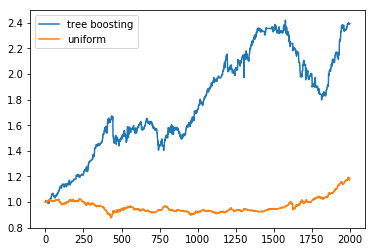

In [247]:
port = [1]
baseline = [1]
trading_coins = [5]
threshold_short = .2
threshold_long = .0
returns_boosting = []
returns_unif = []
status = ["" for i in range(11)]
for i in range(len(preds[0])):
    r = 0
    rb = 0
    for coin in range(11):
        rb += ret[split_index+i,coin] / 11
        if coin in trading_coins:
            if preds[coin][i] > 0.5 + threshold_long:
                if status[coin] == 'long':
                    fee = 0
                else:
                    fee = .0025
                r += (ret[split_index+i,coin] - fee )/ len(trading_coins) 
                status[coin] = 'long'
            elif preds[coin][i] <  0.5 - threshold_short:
                if status[coin] == "short":
                    fee = 0
                else:
                    fee = .0025
                r += (-ret[split_index+i,coin] - fee) / len(trading_coins) 
                status[coin] = 'short'
    returns_unif.append(rb)
    returns_boosting.append(r)
    val = port[-1] * (1+r)
    valb = baseline[-1]*(1+rb)
    port.append(val)
    baseline.append(valb)
plt.plot(port,label="tree boosting")
plt.plot(baseline,label="uniform")
plt.legend()

In [187]:
np.mean(returns_unif)/np.std(returns_unif)

0.029683821394980308

In [227]:
np.mean(returns_boosting)/np.std(returns_boosting)

0.11364366793134462

In [240]:
np.mean(returns_boosting)

-0.00024966021814054986

In [234]:
np.sum(np.array(returns_boosting)==0)/len(returns_boosting)

0.634

In [245]:
preds[5]

array([0.37217602, 0.2493294 , 0.34191307, ..., 0.5072349 , 0.35098737,
       0.42038405], dtype=float32)

In [331]:
d = {"a":1,"b":2}
for k in d:
    print(k)
    #print(v)
    print("next")

a
next
b
next
